In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer, KNNImputer
from scipy.stats import pearsonr

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error,
                             median_absolute_error, explained_variance_score, max_error)
from sklearn.preprocessing import StandardScaler
import copy

np.random.seed(0)

In [20]:
df_train = pd.read_csv("/Users/meskara/Desktop/Github/Real_Estatet_endtoend/src/extracted_data/AmesHousing.csv")
df_test  = pd.read_csv("test.csv")
print("Training data shape (before dropping Id):", df_train.shape)
print("Test data shape (before dropping Id):", df_test.shape)

Training data shape (before dropping Id): (2930, 82)


In [4]:
if "Id" in df_train.columns:
    df_train.drop("Id", axis=1, inplace=True)
if "Id" in df_test.columns:
    df_test.drop("Id", axis=1, inplace=True)

print("Training data shape (after dropping Id):", df_train.shape)
print("Test data shape (after dropping Id):", df_test.shape)

Training data shape (after dropping Id): (1460, 80)
Test data shape (after dropping Id): (1459, 79)


In [5]:
target_variable = 'SalePrice'  
numeric_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
if target_variable in numeric_cols:
    numeric_cols.remove(target_variable)
categorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()

In [ ]:
def impute_numeric_iterative(df, cols):
    imputer = IterativeImputer(random_state=0)
    df_imputed = df.copy()
    df_imputed[cols] = imputer.fit_transform(df_imputed[cols])
    return df_imputed

def impute_numeric_knn(df, cols, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = df.copy()
    df_imputed[cols] = imputer.fit_transform(df_imputed[cols])
    return df_imputed

def single_imputation(df):
    imputed_values = {}  
    num_cols = df.select_dtypes(include=['number']).columns
    for col in num_cols:
        if df[col].isna().any():
            skewness = df[col].skew()
            mode_value = df[col].mode()[0]
            mean_value = df[col].mean()
            median_value = df[col].median()

            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()

            if abs(skewness) > 1:
                if mode_value == 0 and df[col].value_counts(normalize=True).iloc[0] > 0.3:
                    impute_value = mode_value
                    method = "Mode (0)"
                else:
                    impute_value = median_value
                    method = "Median"
            elif outliers > 0:
                impute_value = median_value
                method = "Median"
            else:
                impute_value = mean_value
                method = "Mean"

            imputed_values[col] = (impute_value, method)
            df[col].fillna(impute_value, inplace=True)
            print(f"Column: {col} | Imputation Method: {method} | Imputed Value: {impute_value:.2f}")
    return df

In [7]:
def impute_categorical_ml(df, cols, target):
    df_imputed = df.copy()
    from sklearn.preprocessing import LabelEncoder
    for col in cols:
        if df_imputed[col].isnull().sum() > 0:
            not_missing = df_imputed[df_imputed[col].notnull()]
            missing = df_imputed[df_imputed[col].isnull()]
            predictors = [c for c in df_imputed.columns if c not in [col, target]]
            temp = df_imputed[predictors].copy()
            for pc in predictors:
                if temp[pc].isnull().sum() > 0:
                    temp[pc].fillna(temp[pc].mode()[0], inplace=True)
            temp_encoded = temp.copy()
            for pc in predictors:
                le = LabelEncoder()
                temp_encoded[pc] = le.fit_transform(temp[pc].astype(str))
            X_train = temp_encoded.loc[not_missing.index]
            y_train = not_missing[col]
            le_target = LabelEncoder()
            y_train_enc = le_target.fit_transform(y_train.astype(str))
            X_missing = temp_encoded.loc[missing.index]
            clf = RandomForestClassifier(n_estimators=100, random_state=0)
            clf.fit(X_train, y_train_enc)
            y_pred_enc = clf.predict(X_missing)
            y_pred = le_target.inverse_transform(y_pred_enc)
            df_imputed.loc[missing.index, col] = y_pred
    return df_imputed

In [8]:
def combine_imputed(df_numeric, df_categorical, categorical_cols):
    df_combined = df_numeric.copy()
    for col in categorical_cols:
        df_combined[col] = df_categorical[col]
    return df_combined


In [9]:
def plot_missing_counts(df, title=""):
    missing_counts = df.isnull().sum()
    missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
    if missing_counts.empty:
        print(f"{title}: No missing values.")
        return
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_counts.index, y=missing_counts.values, palette="viridis")
    plt.title(title)
    plt.xlabel("Columns")
    plt.ylabel("Missing Count")
    plt.xticks(rotation=90)
    plt.show()

Missing values in original training data:
PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
MasVnrType      872
               ... 
Heating           0
HeatingQC         0
MSZoning          0
1stFlrSF          0
SalePrice         0
Length: 80, dtype: int64


/var/folders/8s/d6wh7tvn0_3c5hg_n38wk1400000gp/T/ipykernel_85274/1542364241.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_counts.index, y=missing_counts.values, palette="viridis")


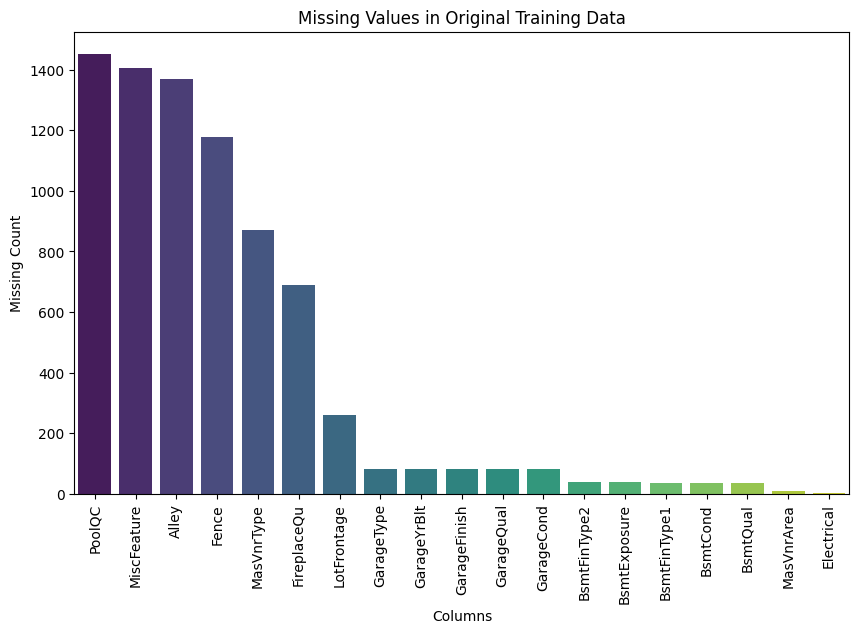

In [10]:
print("Missing values in original training data:")
print(df_train.isnull().sum().sort_values(ascending=False))
plot_missing_counts(df_train, "Missing Values in Original Training Data")

In [11]:
df_train_numeric_iterative = impute_numeric_iterative(df_train.copy(), numeric_cols)
df_train_numeric_knn = impute_numeric_knn(df_train.copy(), numeric_cols)
df_train_numeric_single = single_imputation(df_train.copy())

Column: LotFrontage | Imputation Method: Median | Imputed Value: 69.00
Column: MasVnrArea | Imputation Method: Mode (0) | Imputed Value: 0.00
Column: GarageYrBlt | Imputation Method: Mean | Imputed Value: 1978.51


/var/folders/8s/d6wh7tvn0_3c5hg_n38wk1400000gp/T/ipykernel_85274/388226312.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(impute_value, inplace=True)
/var/folders/8s/d6wh7tvn0_3c5hg_n38wk1400000gp/T/ipykernel_85274/388226312.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

In [12]:
df_train_categorical_ml = impute_categorical_ml(df_train.copy(), categorical_cols, target_variable)

/var/folders/8s/d6wh7tvn0_3c5hg_n38wk1400000gp/T/ipykernel_85274/1648147045.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  temp[pc].fillna(temp[pc].mode()[0], inplace=True)
/var/folders/8s/d6wh7tvn0_3c5hg_n38wk1400000gp/T/ipykernel_85274/1648147045.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

In [13]:
df_train_imputed_iterative = combine_imputed(df_train_numeric_iterative, df_train_categorical_ml, categorical_cols)
df_train_imputed_knn = combine_imputed(df_train_numeric_knn, df_train_categorical_ml, categorical_cols)
df_train_imputed_single = combine_imputed(df_train_numeric_single, df_train_categorical_ml, categorical_cols)

In [14]:
print("Missing values in Iterative-imputed training data:")
print(df_train_imputed_iterative.isnull().sum().sort_values(ascending=False))
plot_missing_counts(df_train_imputed_iterative, "Missing Values in Iterative-Imputed Training Data")


Missing values in Iterative-imputed training data:
MSSubClass     0
MSZoning       0
GarageYrBlt    0
GarageType     0
FireplaceQu    0
              ..
MasVnrArea     0
MasVnrType     0
Exterior2nd    0
Exterior1st    0
SalePrice      0
Length: 80, dtype: int64
Missing Values in Iterative-Imputed Training Data: No missing values.


In [15]:
print("Missing values in KNN-imputed training data:")
print(df_train_imputed_knn.isnull().sum().sort_values(ascending=False))
plot_missing_counts(df_train_imputed_knn, "Missing Values in KNN-Imputed Training Data")

Missing values in KNN-imputed training data:
MSSubClass     0
MSZoning       0
GarageYrBlt    0
GarageType     0
FireplaceQu    0
              ..
MasVnrArea     0
MasVnrType     0
Exterior2nd    0
Exterior1st    0
SalePrice      0
Length: 80, dtype: int64
Missing Values in KNN-Imputed Training Data: No missing values.


In [16]:
print("Missing values in Single-imputed training data:")
print(df_train_imputed_single.isnull().sum().sort_values(ascending=False))
plot_missing_counts(df_train_imputed_single, "Missing Values in Single-Imputed Training Data")

Missing values in Single-imputed training data:
MSSubClass     0
MSZoning       0
GarageYrBlt    0
GarageType     0
FireplaceQu    0
              ..
MasVnrArea     0
MasVnrType     0
Exterior2nd    0
Exterior1st    0
SalePrice      0
Length: 80, dtype: int64
Missing Values in Single-Imputed Training Data: No missing values.


In [17]:
imputation_datasets = {
    "Iterative": df_train_imputed_iterative,
    "KNN": df_train_imputed_knn,
    "Single": df_train_imputed_single,
}

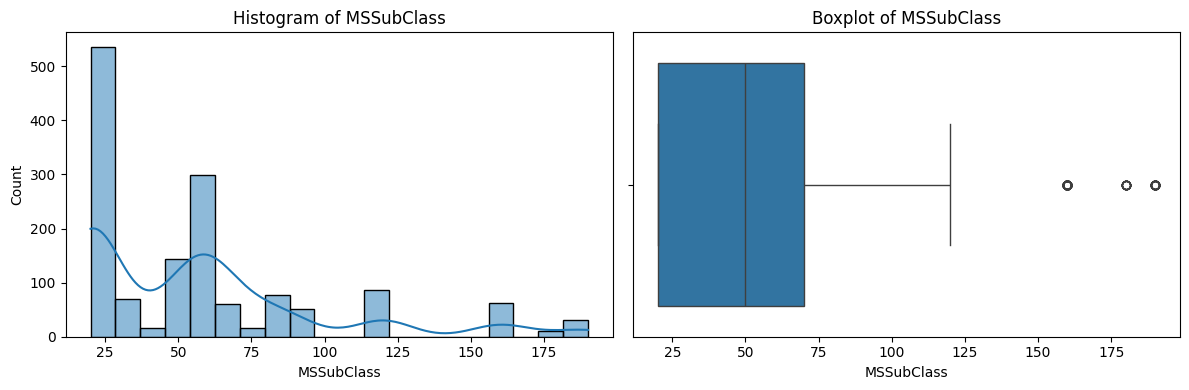

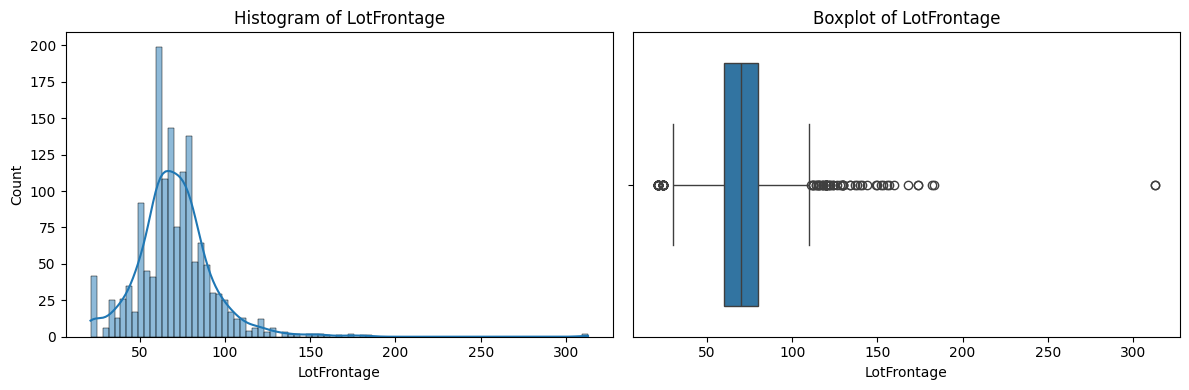

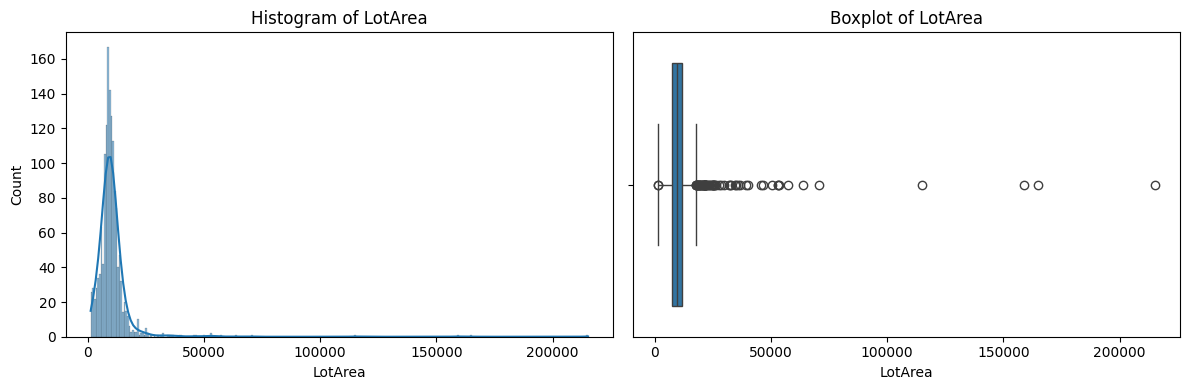

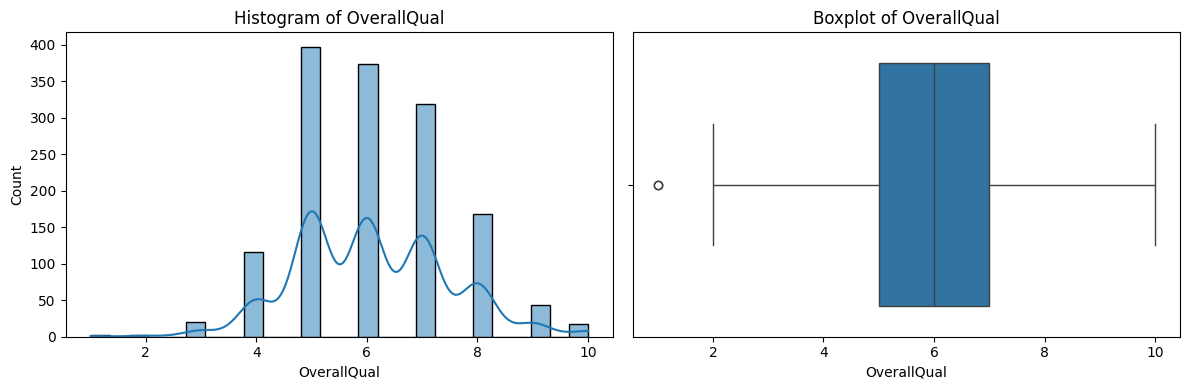

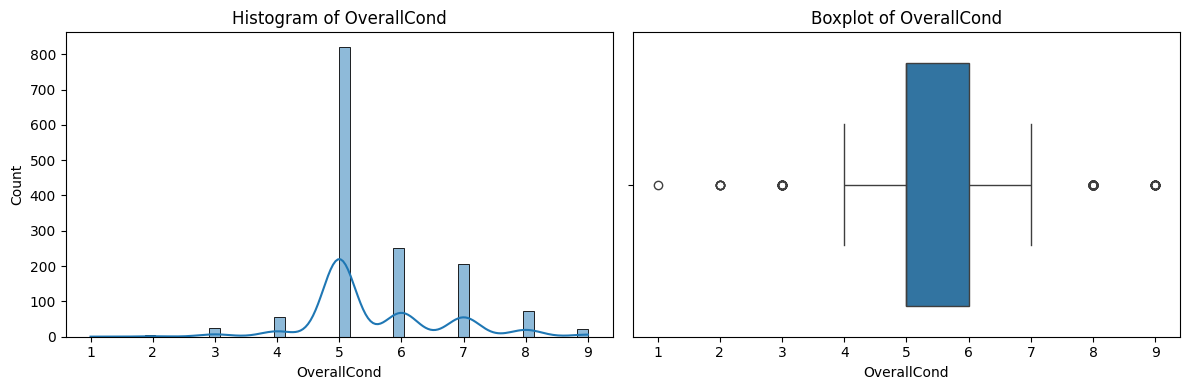

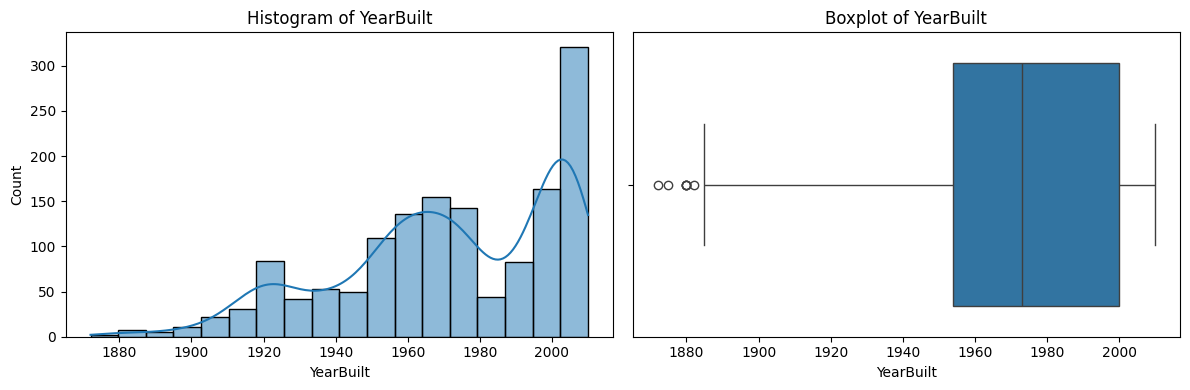

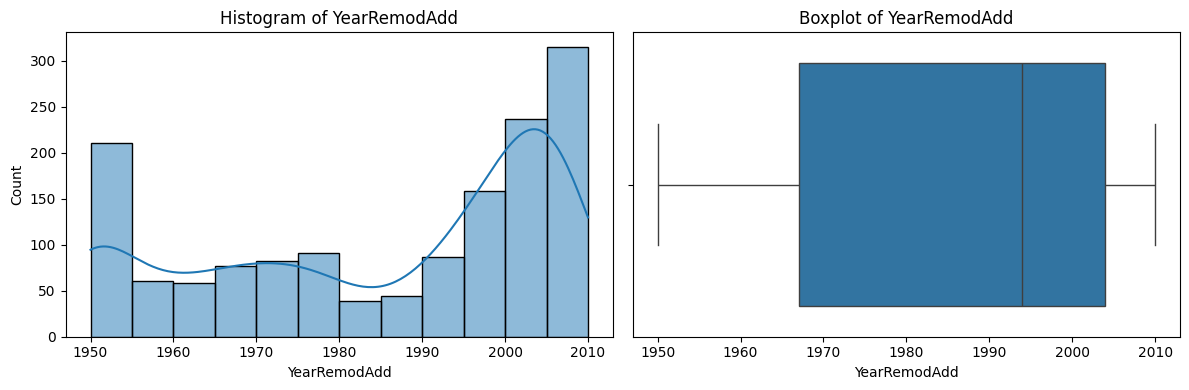

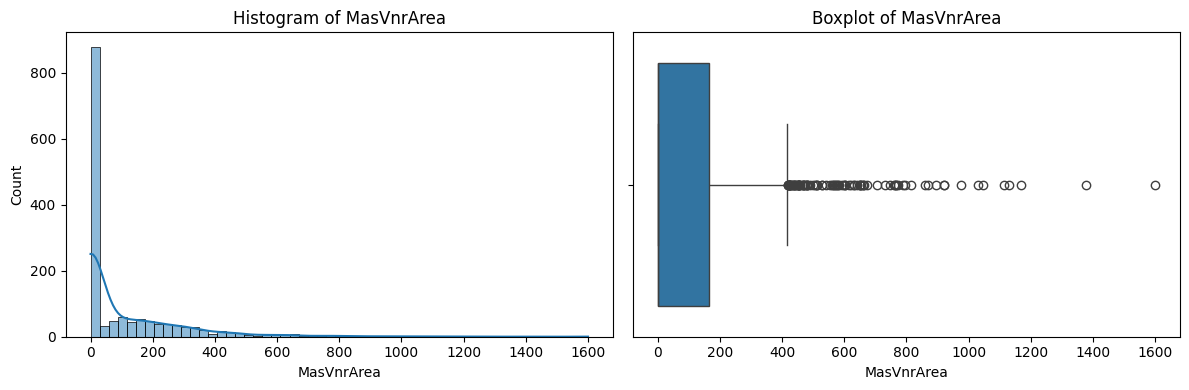

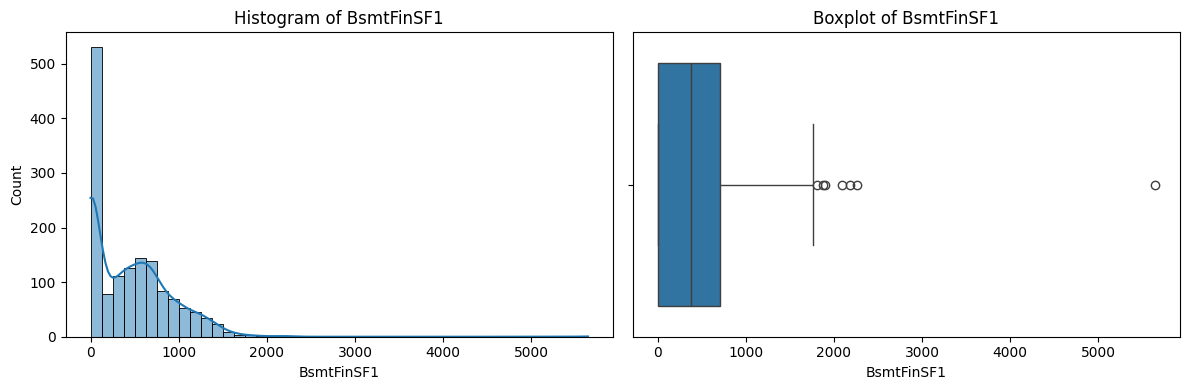

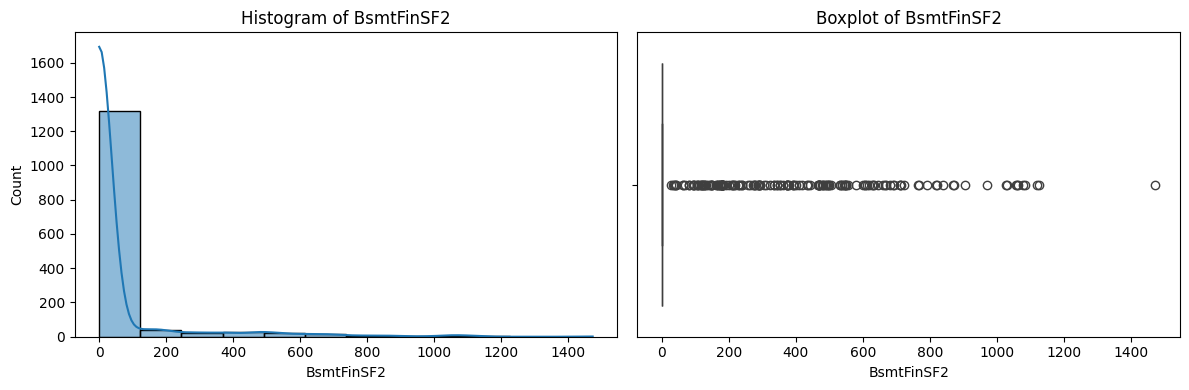

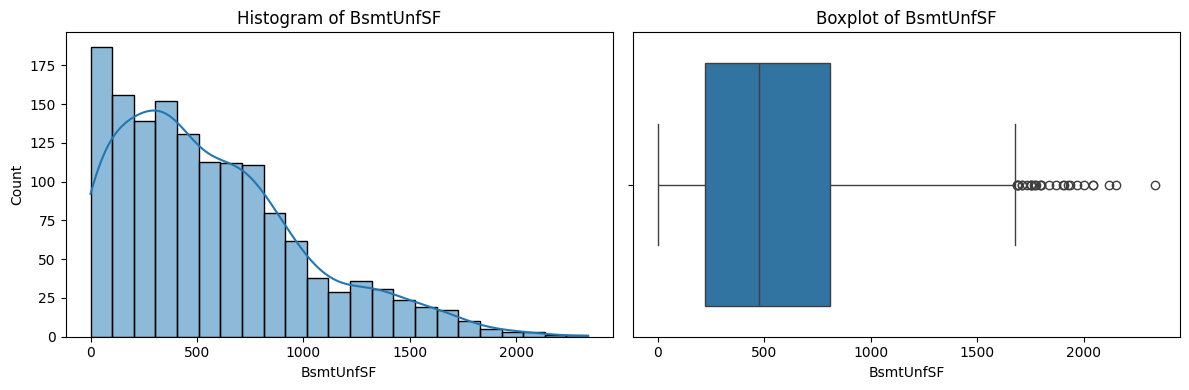

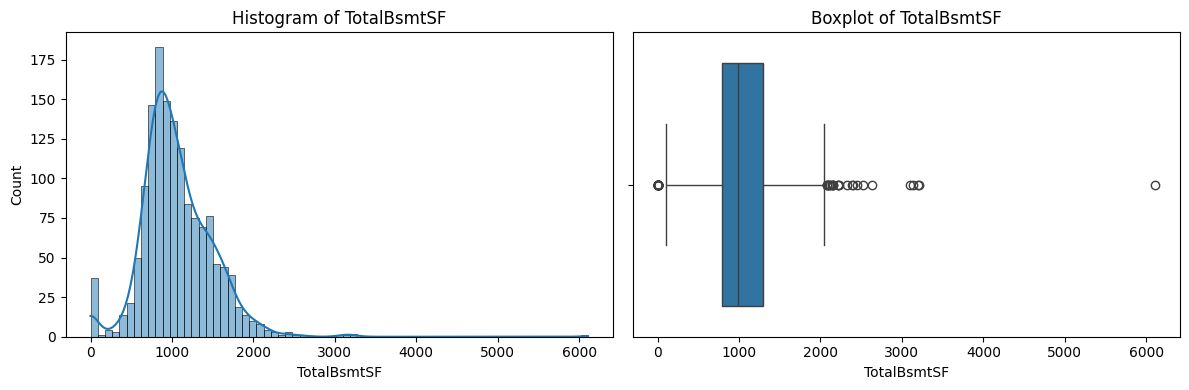

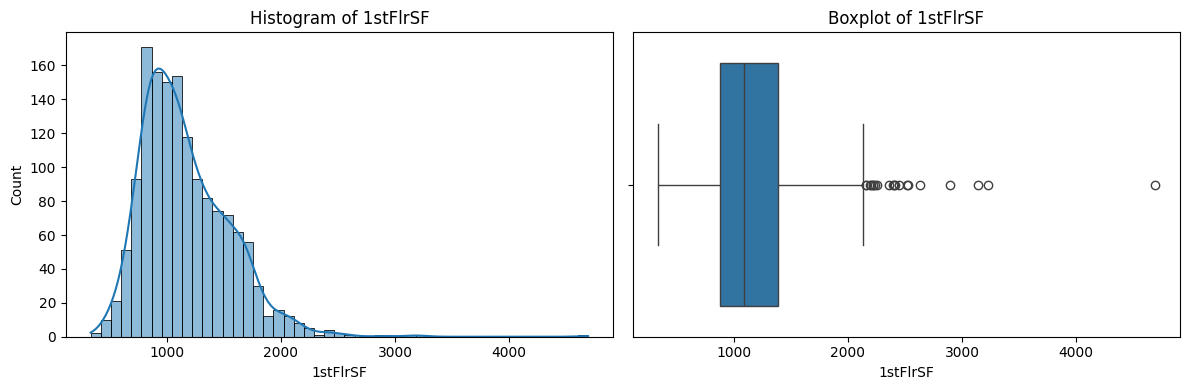

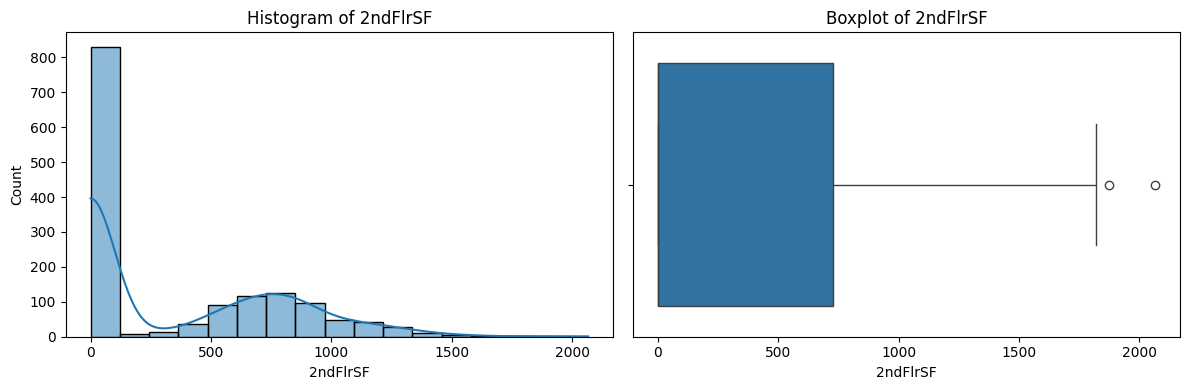

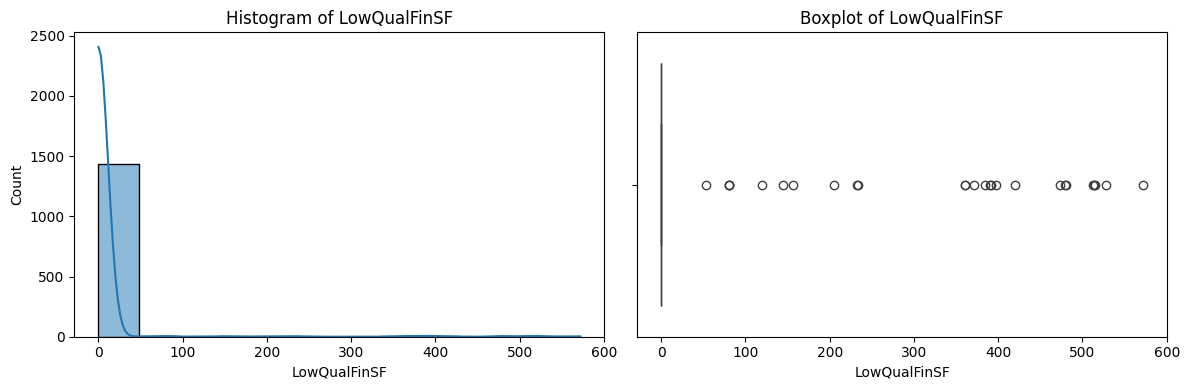

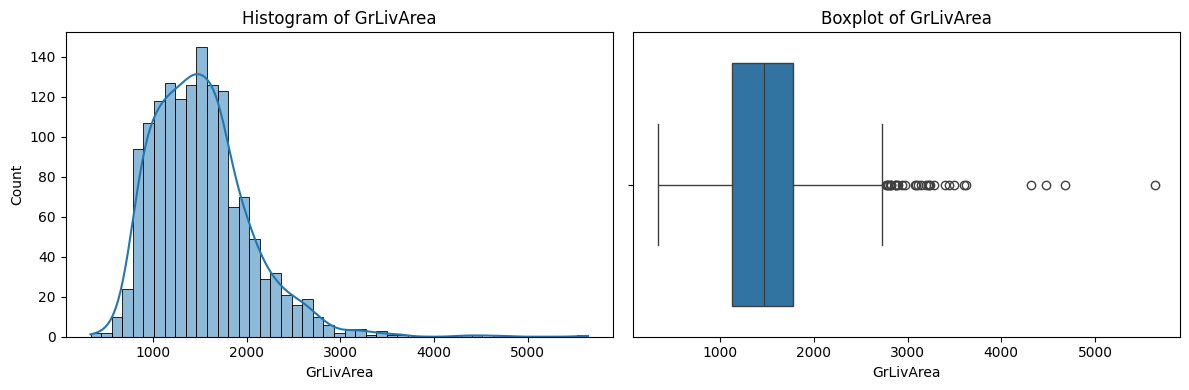

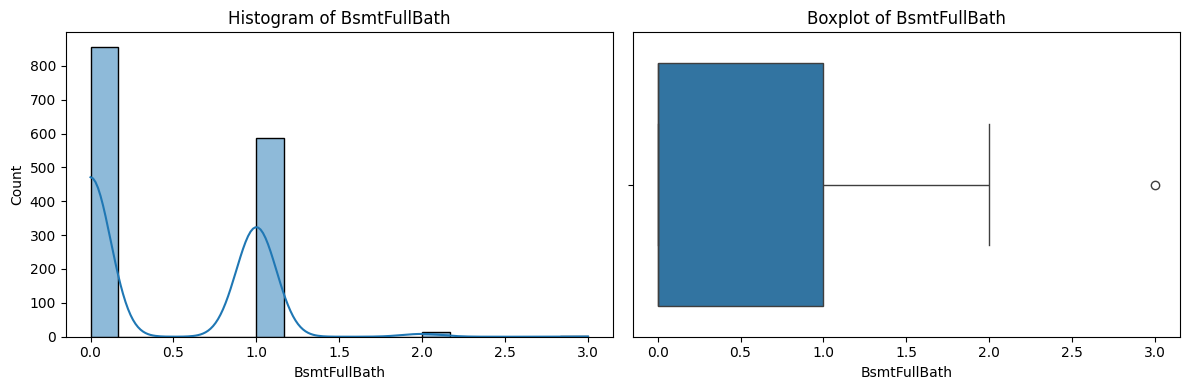

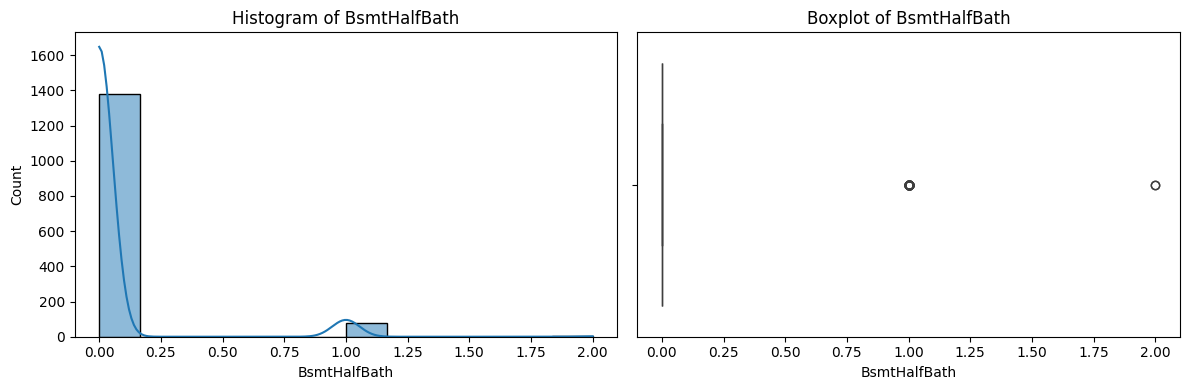

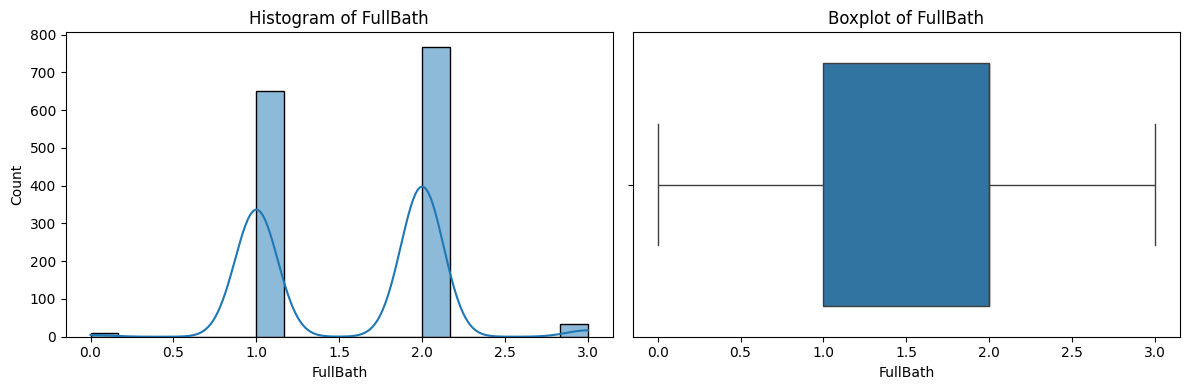

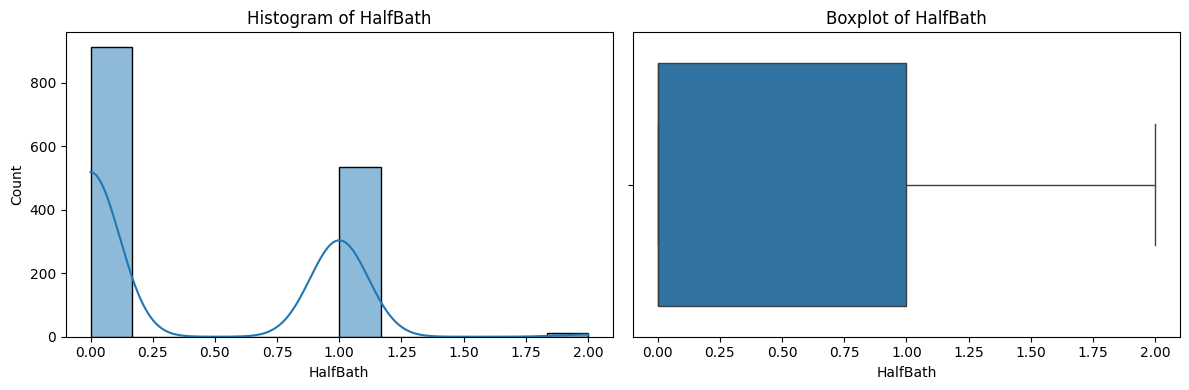

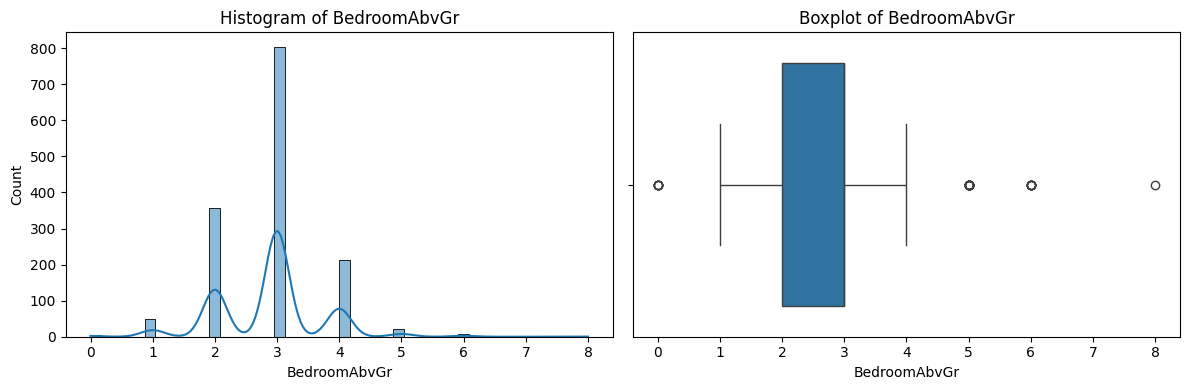

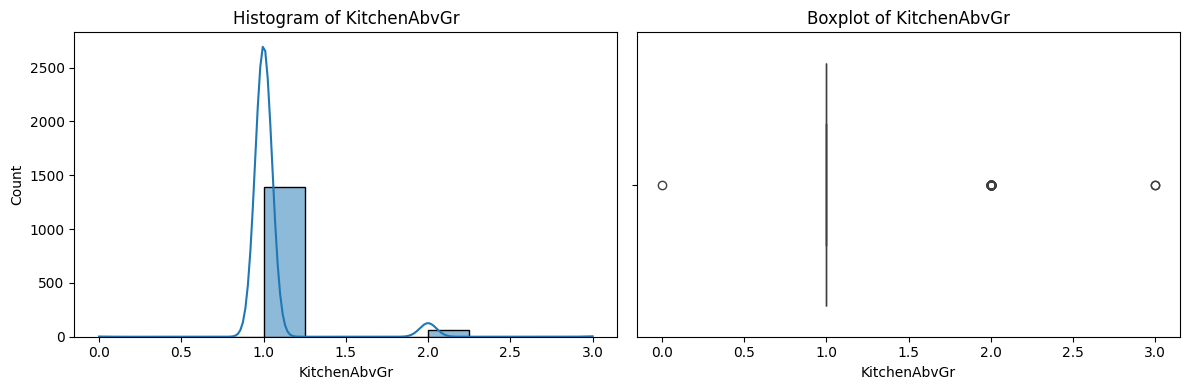

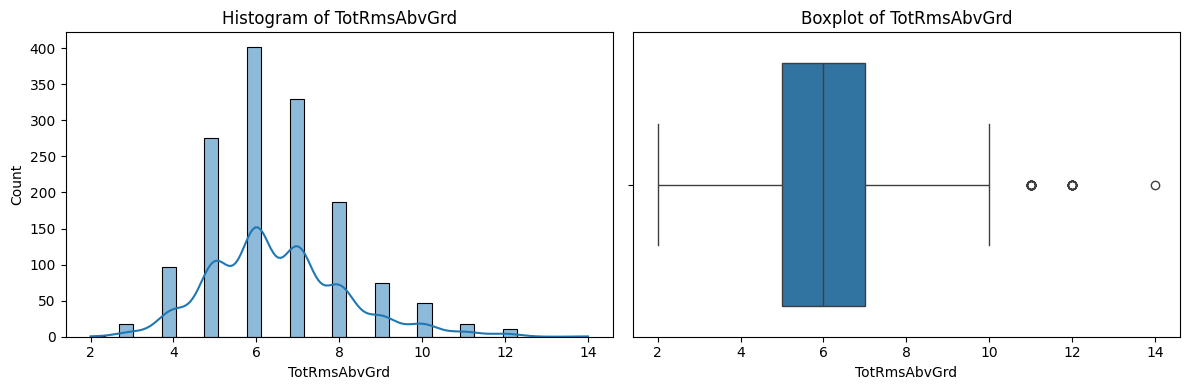

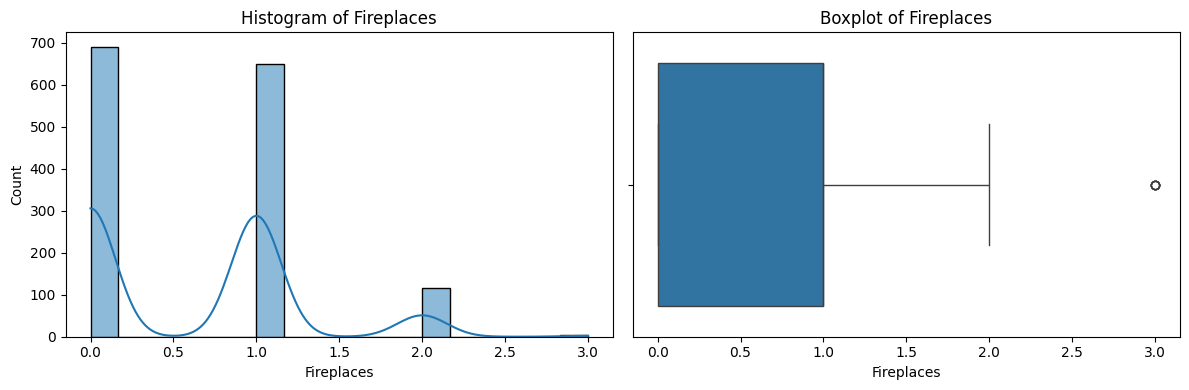

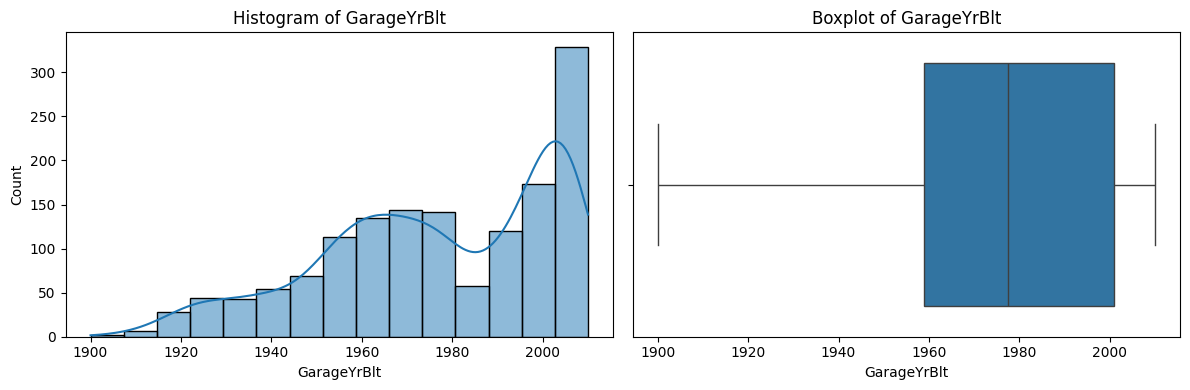

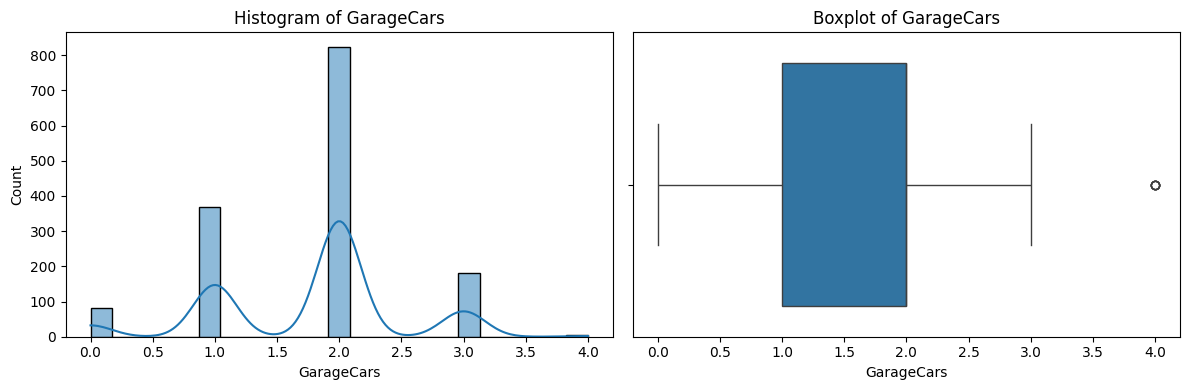

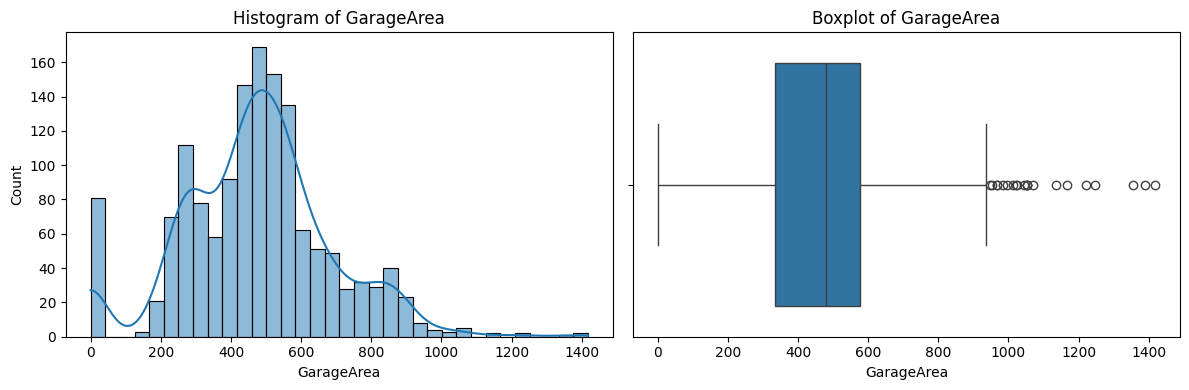

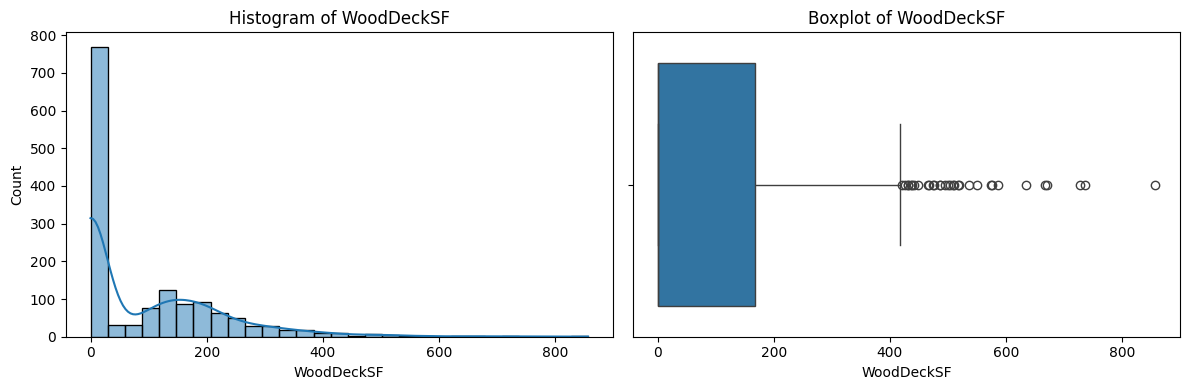

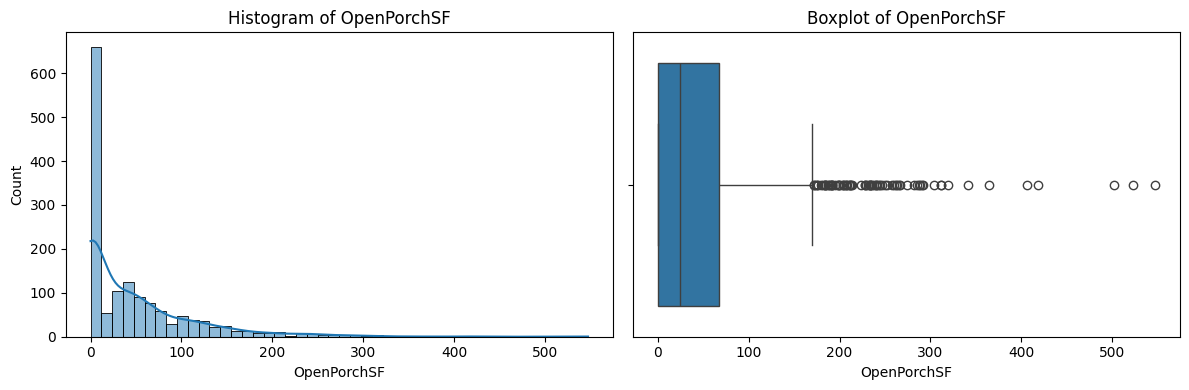

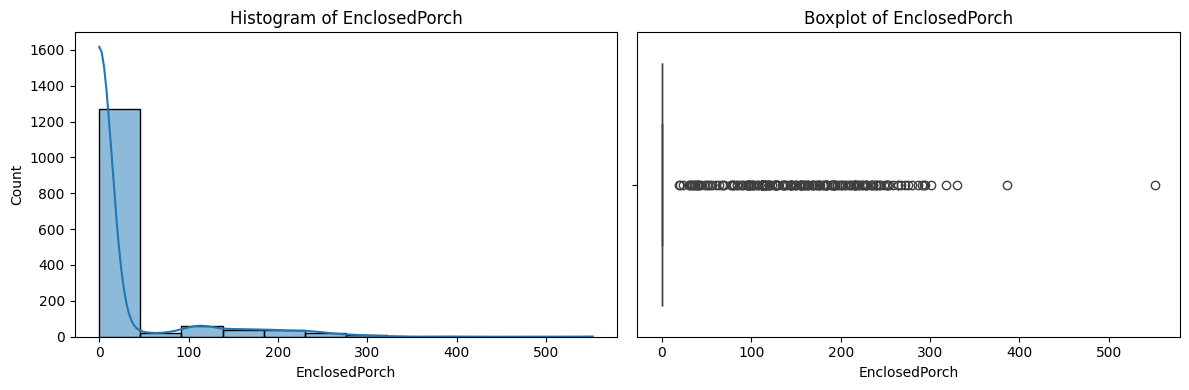

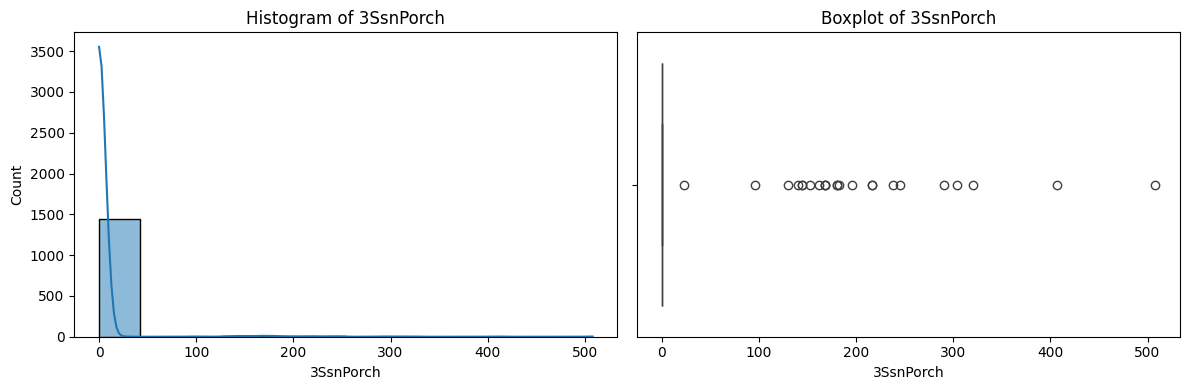

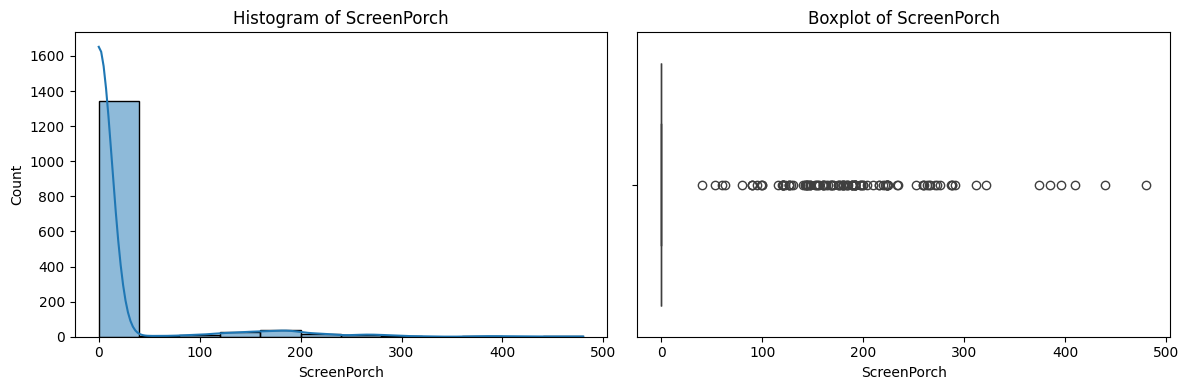

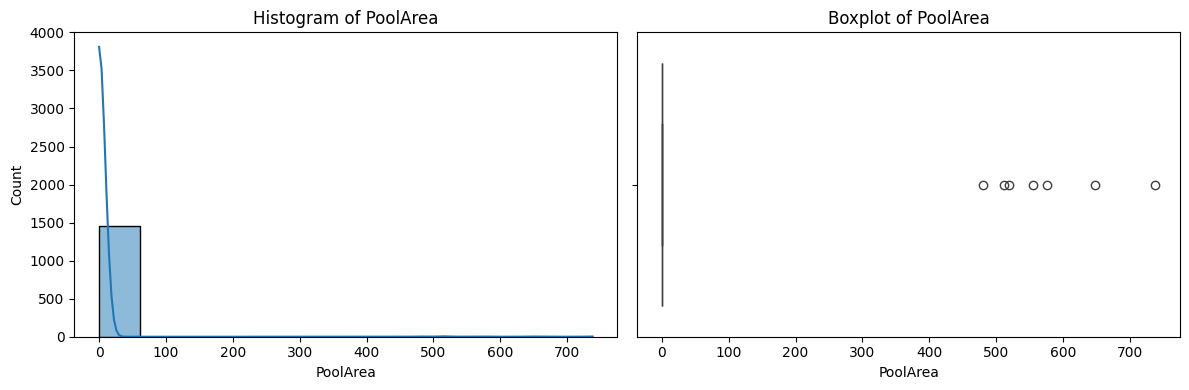

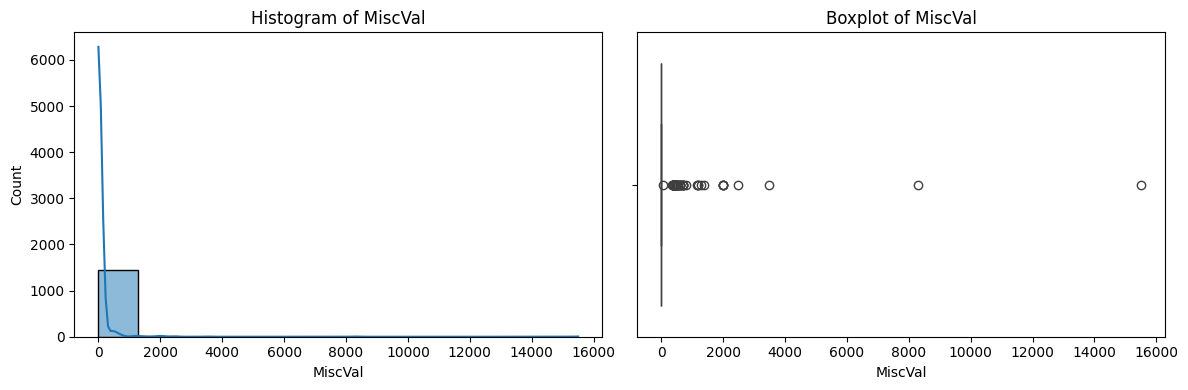

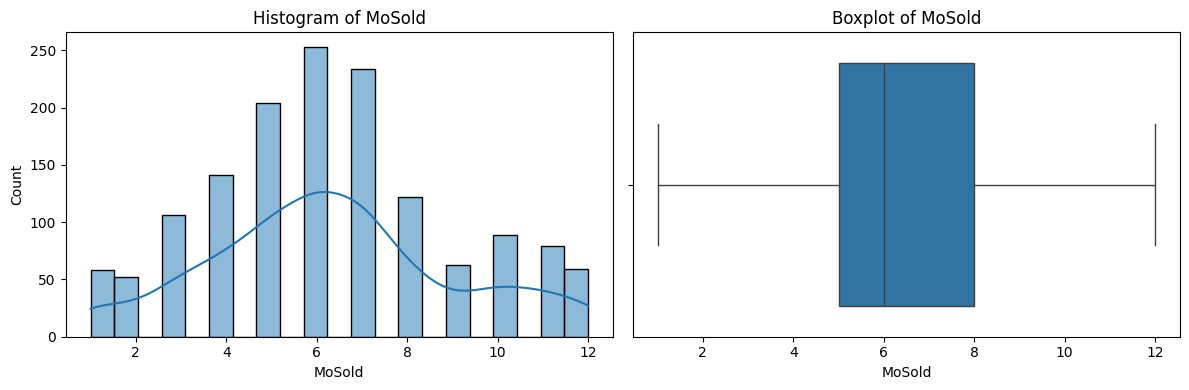

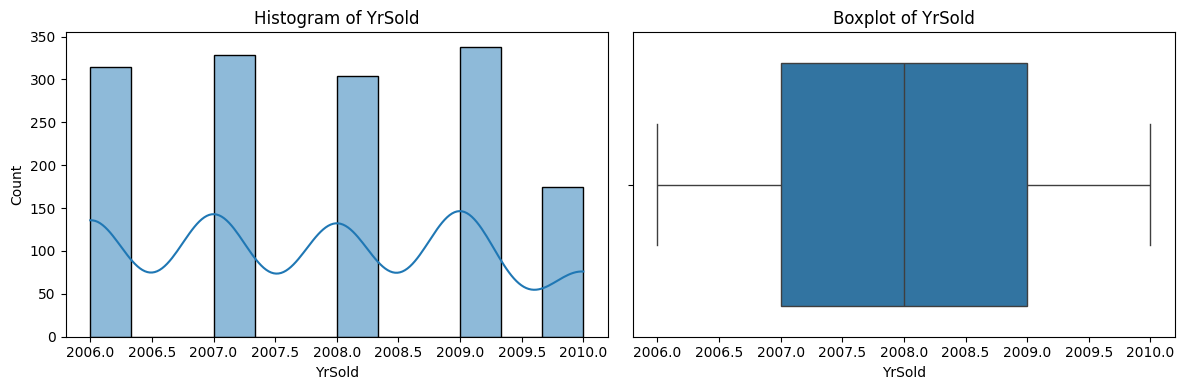

In [18]:
df_iterative = df_train_imputed_iterative.copy()
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df_iterative[col], kde=True, ax=axes[0])
    axes[0].set_title(f"Histogram of {col}")
    sns.boxplot(x=df_iterative[col], ax=axes[1])
    axes[1].set_title(f"Boxplot of {col}")
    plt.tight_layout()
    plt.show()

In [19]:
def preprocess_df(df, target, cat_cols):
    df_proc = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    if target in df_proc.columns:
        X = df_proc.drop(columns=[target])
        y = df_proc[target]
        return X, y
    else:
        return df_proc, None

In [20]:
def correlation_filter(X, y, threshold=0.6):
    df_corr = X.copy()
    df_corr[target_variable] = y
    corr_matrix = df_corr.corr()
    strong_features = corr_matrix[target_variable].drop(target_variable).abs()
    selected_features = strong_features[strong_features >= threshold].index.tolist()
    print(f"Selected features based on correlation (|corr| >= {threshold}):")
    print(selected_features)
    return X[selected_features]

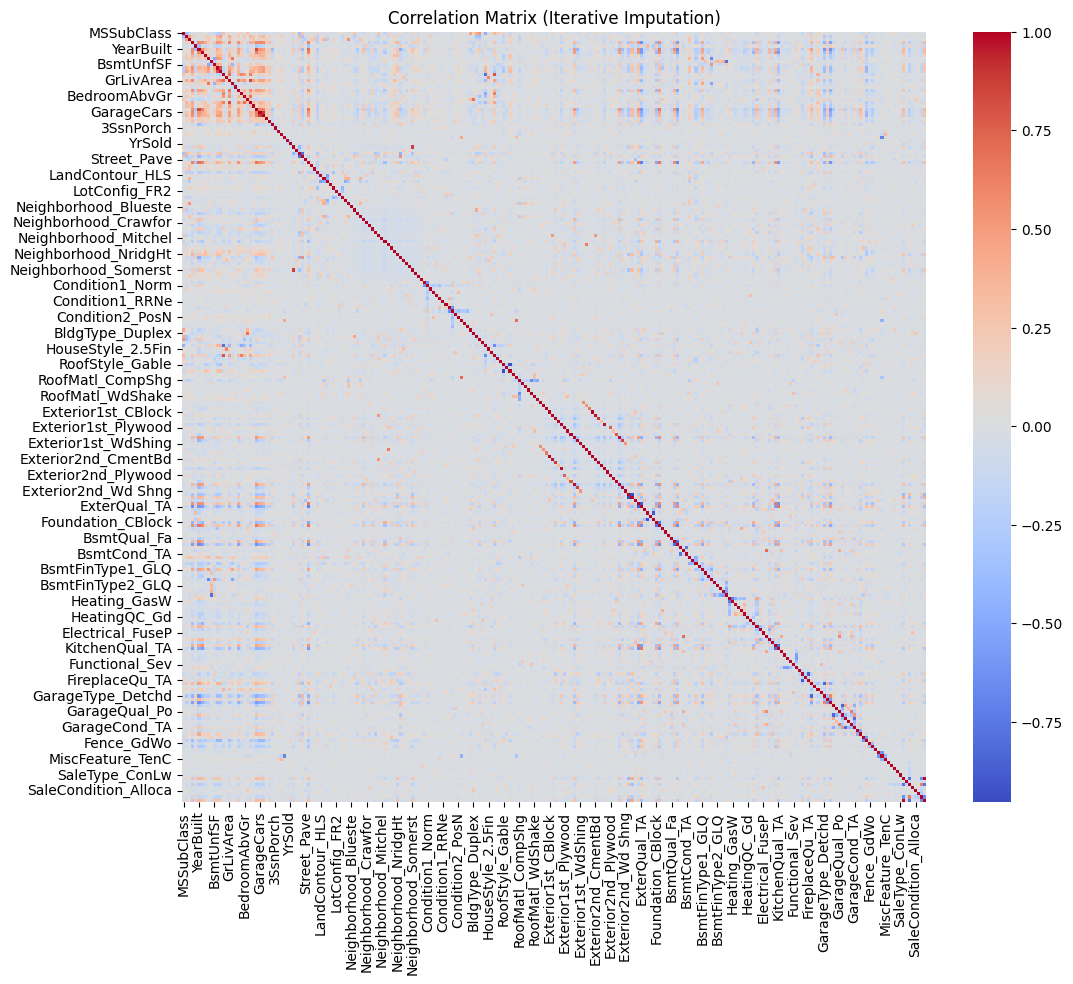

In [21]:
X_all, y_all = preprocess_df(df_train_imputed_iterative, target_variable, categorical_cols)
plt.figure(figsize=(12, 10))
sns.heatmap(X_all.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Matrix (Iterative Imputation)")
plt.show()

In [22]:
X_selected = correlation_filter(X_all, y_all, threshold=0.6)

Selected features based on correlation (|corr| >= 0.6):
['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageCars', 'GarageArea']


In [23]:
tree_models = {
    "RandomForest": RandomForestRegressor(random_state=0, n_jobs=-1),
    "XGBoost": xgb.XGBRegressor(random_state=0, n_jobs=-1),
    "LightGBM": lgb.LGBMRegressor(random_state=0, n_jobs=-1)
}

In [24]:
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    maxerr = max_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'R2': r2, 'MSE': mse, 'RMSE': rmse, 'MAE': mae,
            'MedAE': medae, 'EVS': evs, 'MaxError': maxerr}

In [25]:
results_list = []
scalers = {}

In [26]:
for imp_name, df_imp in imputation_datasets.items():
    X_all, y_all = preprocess_df(df_imp, target_variable, categorical_cols)
    X_all_filtered = correlation_filter(X_all, y_all, threshold=0.6)
    X_train, X_val, y_train, y_val = train_test_split(X_all_filtered, y_all, test_size=0.2, random_state=1)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    scalers[imp_name] = (scaler, X_train.columns)
    
    for model_name, model in tree_models.items():
        mdl = copy.deepcopy(model)
        mdl.fit(X_train_scaled, y_train)
        y_pred = mdl.predict(X_val_scaled)
        metrics = compute_metrics(y_val, y_pred)
        metrics.update({"Imputation": imp_name, "Model": model_name})
        results_list.append(metrics)
        print(f"Imputation: {imp_name} | Model: {model_name} | Metrics: {metrics}")

results_df = pd.DataFrame(results_list)
print("\nSummary of Evaluation Metrics (Validation):")
print(results_df)

Selected features based on correlation (|corr| >= 0.6):
['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageCars', 'GarageArea']
Imputation: Iterative | Model: RandomForest | Metrics: {'R2': 0.8821909239264354, 'MSE': 840207659.7973775, 'RMSE': 28986.335742852658, 'MAE': 20479.046235895952, 'MedAE': 14164.89, 'EVS': 0.8821920911689856, 'MaxError': 151549.72999999998, 'Imputation': 'Iterative', 'Model': 'RandomForest'}
Imputation: Iterative | Model: XGBoost | Metrics: {'R2': 0.8669953346252441, 'MSE': 948581668.4708562, 'RMSE': 30799.05304503462, 'MAE': 21756.29312928082, 'MedAE': 15497.90625, 'EVS': 0.8670117929222535, 'MaxError': 167772.15625, 'Imputation': 'Iterative', 'Model': 'XGBoost'}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1036
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 6
[L

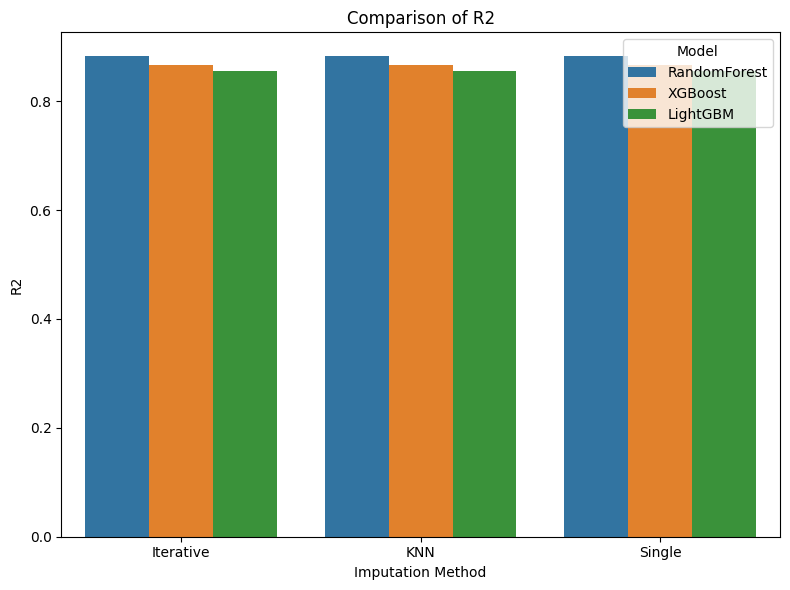

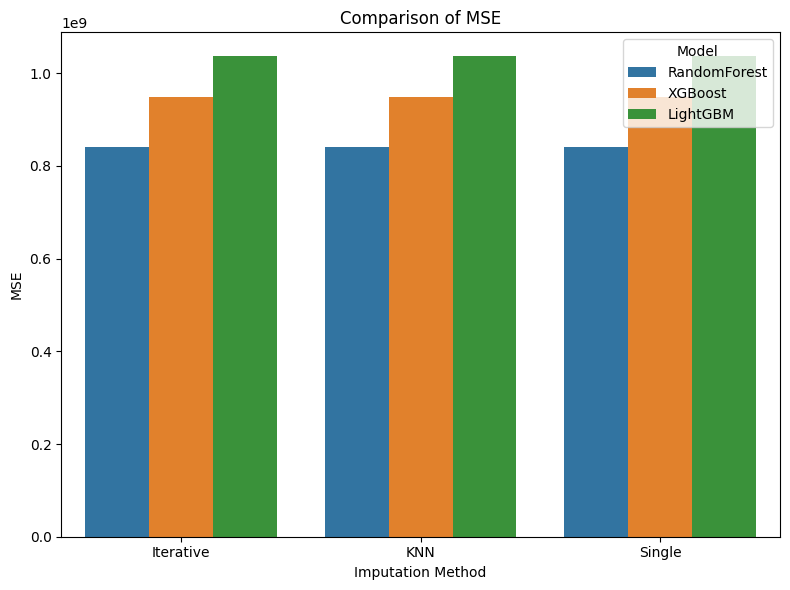

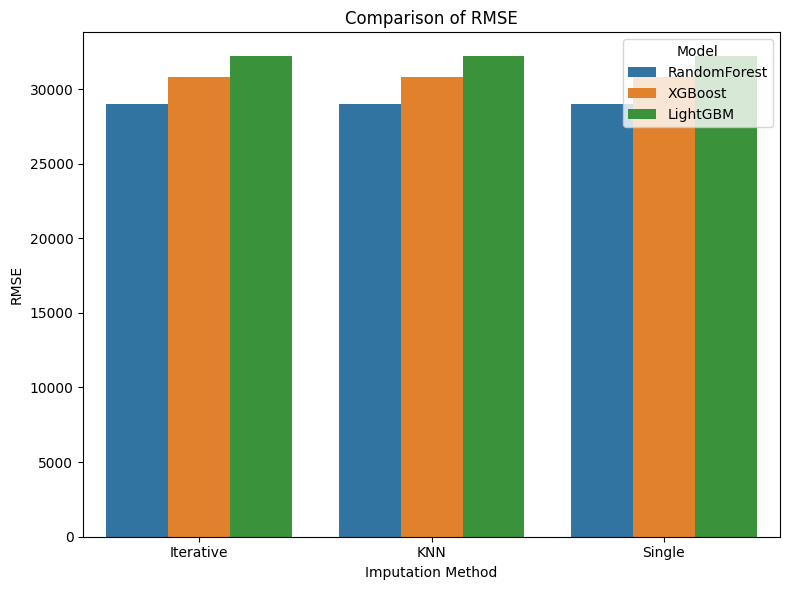

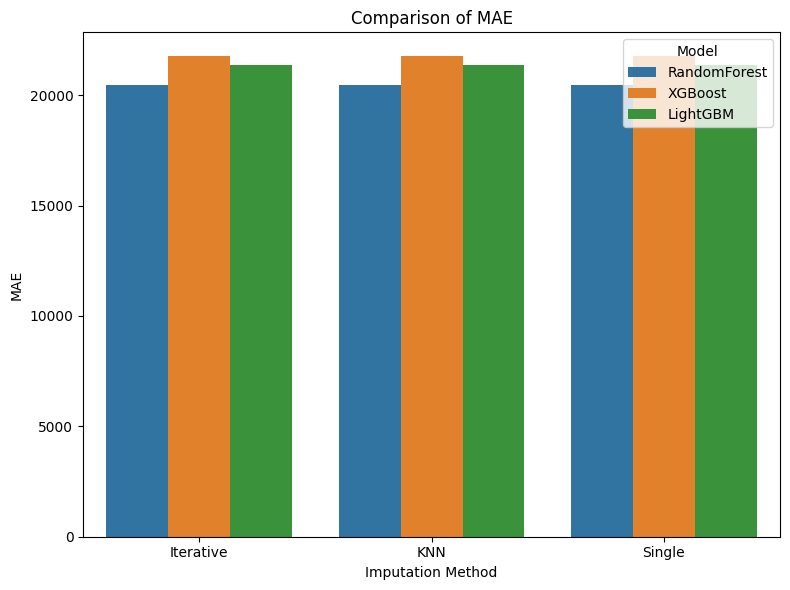

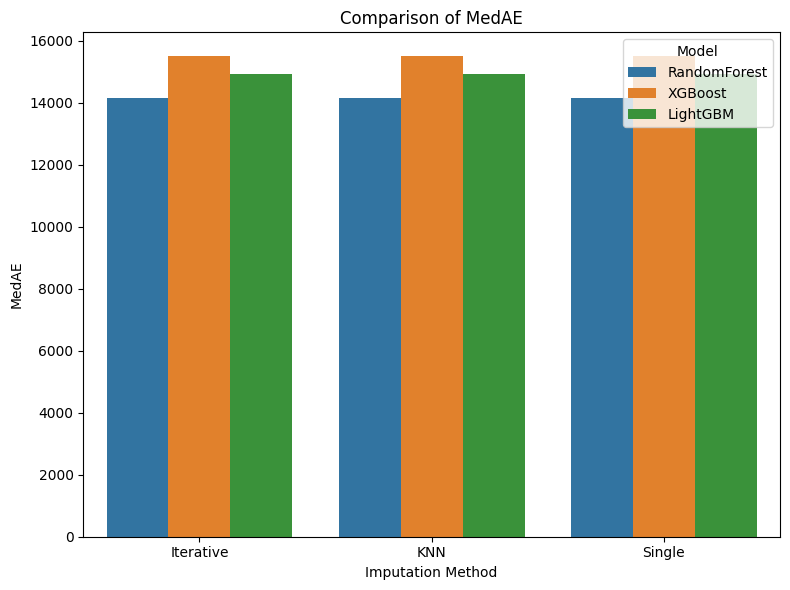

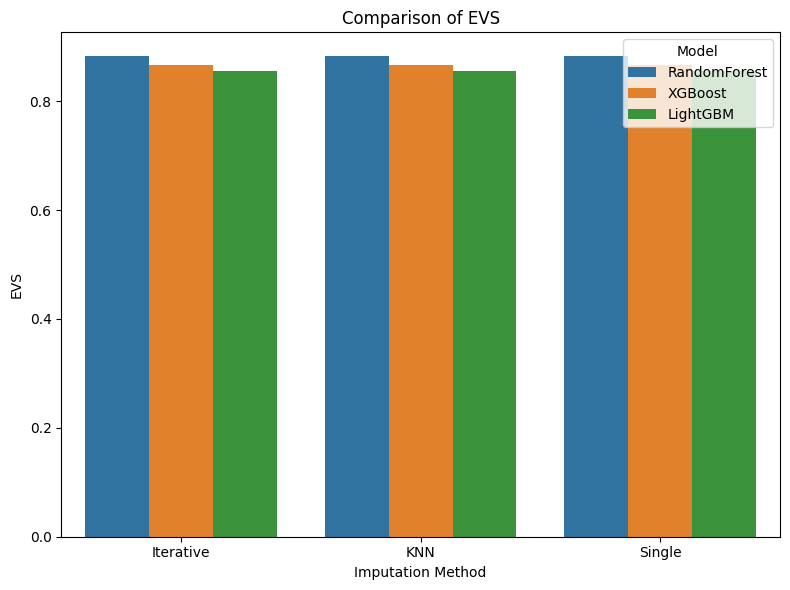

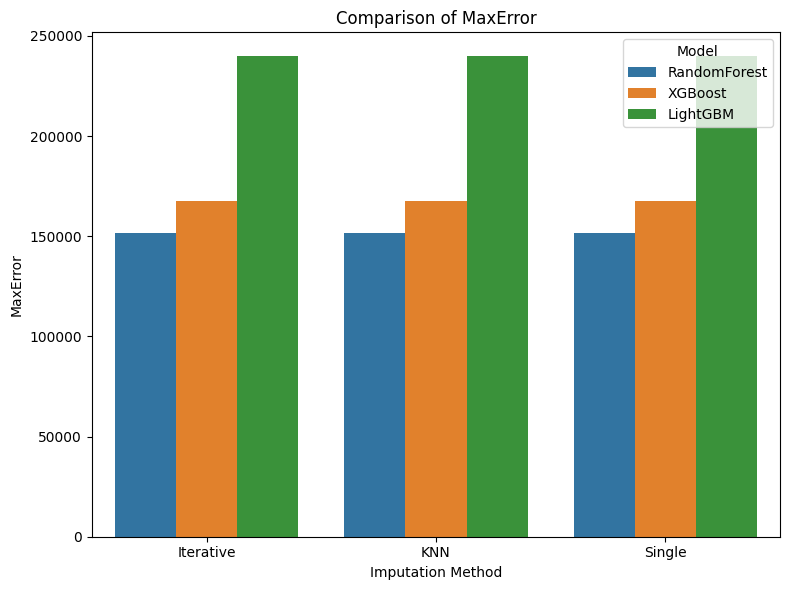

In [27]:
metric_list = ['R2', 'MSE', 'RMSE', 'MAE', 'MedAE', 'EVS', 'MaxError']
for metric in metric_list:
    plt.figure(figsize=(8, 6))
    sns.barplot(data=results_df, x="Imputation", y=metric, hue="Model")
    plt.title(f"Comparison of {metric}")
    plt.ylabel(metric)
    plt.xlabel("Imputation Method")
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()

In [28]:
best_model_row = results_df.loc[results_df['R2'].idxmax()]
best_imp = best_model_row['Imputation']
best_model_name = best_model_row['Model']
print("Best Model based on Validation R²:")
print(best_model_row)

Best Model based on Validation R²:
R2                    0.882191
MSE           840207659.797377
RMSE              28986.335743
MAE               20479.046236
MedAE                 14164.89
EVS                   0.882192
MaxError             151549.73
Imputation           Iterative
Model             RandomForest
Name: 0, dtype: object


In [29]:
df_best = imputation_datasets[best_imp]
X_all_best, y_all_best = preprocess_df(df_best, target_variable, categorical_cols)
X_all_best_filtered = correlation_filter(X_all_best, y_all_best, threshold=0.6)
X_train, X_val, y_train, y_val = train_test_split(X_all_best_filtered, y_all_best, test_size=0.2, random_state=1)
scaler_best = StandardScaler()
X_train_scaled = scaler_best.fit_transform(X_train)
X_val_scaled = scaler_best.transform(X_val)

Selected features based on correlation (|corr| >= 0.6):
['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageCars', 'GarageArea']


In [30]:
if best_model_name == "RandomForest":
    best_model = RandomForestRegressor(random_state=0, n_jobs=-1)
elif best_model_name == "XGBoost":
    best_model = xgb.XGBRegressor(random_state=0, n_jobs=-1)
elif best_model_name == "LightGBM":
    best_model = lgb.LGBMRegressor(random_state=0, n_jobs=-1)
else:
    best_model = None

In [31]:
best_model = copy.deepcopy(best_model)
best_model.fit(X_train_scaled, y_train)
y_pred_val = best_model.predict(X_val_scaled)

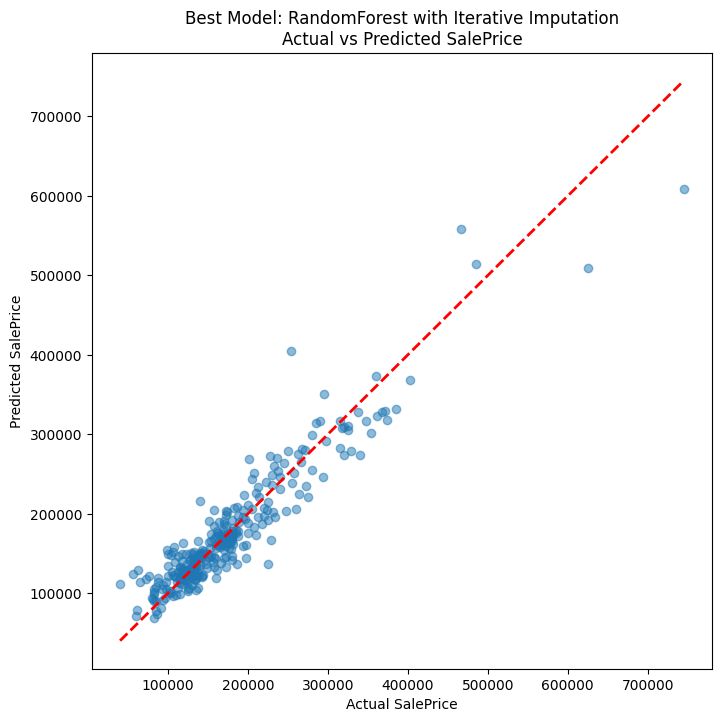

In [32]:
plt.figure(figsize=(8, 8))
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title(f"Best Model: {best_model_name} with {best_imp} Imputation\nActual vs Predicted SalePrice")
plt.show()

In [33]:
best_metrics = compute_metrics(y_val, y_pred_val)
print("Validation Metrics for Best Model:")
print(best_metrics)

Validation Metrics for Best Model:
{'R2': 0.8821909239264354, 'MSE': 840207659.7973775, 'RMSE': 28986.335742852658, 'MAE': 20479.046235895952, 'MedAE': 14164.89, 'EVS': 0.8821920911689856, 'MaxError': 151549.72999999998}


In [34]:
df_test_numeric_iterative = impute_numeric_iterative(df_test.copy(), numeric_cols)
df_test_numeric_knn = impute_numeric_knn(df_test.copy(), numeric_cols)
df_test_numeric_single = single_imputation(df_test.copy())

Column: LotFrontage | Imputation Method: Median | Imputed Value: 67.00
Column: MasVnrArea | Imputation Method: Mode (0) | Imputed Value: 0.00
Column: BsmtFinSF1 | Imputation Method: Mode (0) | Imputed Value: 0.00
Column: BsmtFinSF2 | Imputation Method: Mode (0) | Imputed Value: 0.00
Column: BsmtUnfSF | Imputation Method: Median | Imputed Value: 460.00
Column: TotalBsmtSF | Imputation Method: Median | Imputed Value: 988.00
Column: BsmtFullBath | Imputation Method: Median | Imputed Value: 0.00
Column: BsmtHalfBath | Imputation Method: Mode (0) | Imputed Value: 0.00
Column: GarageYrBlt | Imputation Method: Median | Imputed Value: 1979.00
Column: GarageCars | Imputation Method: Median | Imputed Value: 2.00
Column: GarageArea | Imputation Method: Median | Imputed Value: 480.00


/Users/meskara/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/var/folders/8s/d6wh7tvn0_3c5hg_n38wk1400000gp/T/ipykernel_85274/388226312.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(impute_value, inplace=True)
/var/folders/8s/d6wh7tvn0_3c5hg_n38wk1400000gp/T/ipykernel_85274/388226312.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chaine

In [35]:
df_test_categorical_ml = impute_categorical_ml(df_test.copy(), categorical_cols, target_variable)

/var/folders/8s/d6wh7tvn0_3c5hg_n38wk1400000gp/T/ipykernel_85274/1648147045.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  temp[pc].fillna(temp[pc].mode()[0], inplace=True)
/var/folders/8s/d6wh7tvn0_3c5hg_n38wk1400000gp/T/ipykernel_85274/1648147045.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

In [36]:
df_test_imputed_iterative = combine_imputed(df_test_numeric_iterative, df_test_categorical_ml, categorical_cols)
df_test_imputed_knn = combine_imputed(df_test_numeric_knn, df_test_categorical_ml, categorical_cols)
df_test_imputed_single = combine_imputed(df_test_numeric_single, df_test_categorical_ml, categorical_cols)

Missing values in original test data:
PoolQC           1456
MiscFeature      1408
Alley            1352
Fence            1169
MasVnrType        894
                 ... 
Electrical          0
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
SaleCondition       0
Length: 79, dtype: int64


/var/folders/8s/d6wh7tvn0_3c5hg_n38wk1400000gp/T/ipykernel_85274/1542364241.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_counts.index, y=missing_counts.values, palette="viridis")


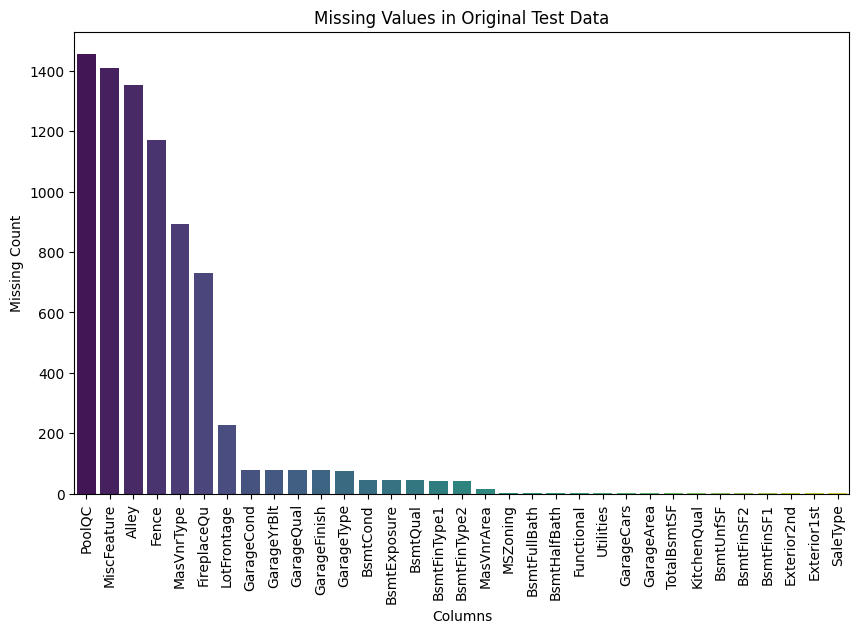

In [37]:
print("Missing values in original test data:")
print(df_test.isnull().sum().sort_values(ascending=False))
plot_missing_counts(df_test, "Missing Values in Original Test Data")

In [38]:
print("Missing values in Iterative-imputed test data:")
print(df_test_imputed_iterative.isnull().sum().sort_values(ascending=False))
plot_missing_counts(df_test_imputed_iterative, "Missing Values in Iterative-Imputed Test Data")

Missing values in Iterative-imputed test data:
MSSubClass       0
BedroomAbvGr     0
GarageType       0
FireplaceQu      0
Fireplaces       0
                ..
MasVnrArea       0
MasVnrType       0
Exterior2nd      0
Exterior1st      0
SaleCondition    0
Length: 79, dtype: int64
Missing Values in Iterative-Imputed Test Data: No missing values.


In [39]:
print("Missing values in KNN-imputed test data:")
print(df_test_imputed_knn.isnull().sum().sort_values(ascending=False))
plot_missing_counts(df_test_imputed_knn, "Missing Values in KNN-Imputed Test Data")

Missing values in KNN-imputed test data:
MSSubClass       0
BedroomAbvGr     0
GarageType       0
FireplaceQu      0
Fireplaces       0
                ..
MasVnrArea       0
MasVnrType       0
Exterior2nd      0
Exterior1st      0
SaleCondition    0
Length: 79, dtype: int64
Missing Values in KNN-Imputed Test Data: No missing values.


In [40]:
print("Missing values in Single-imputed test data:")
print(df_test_imputed_single.isnull().sum().sort_values(ascending=False))
plot_missing_counts(df_test_imputed_single, "Missing Values in Single-Imputed Test Data")

Missing values in Single-imputed test data:
MSSubClass       0
BedroomAbvGr     0
GarageType       0
FireplaceQu      0
Fireplaces       0
                ..
MasVnrArea       0
MasVnrType       0
Exterior2nd      0
Exterior1st      0
SaleCondition    0
Length: 79, dtype: int64
Missing Values in Single-Imputed Test Data: No missing values.


In [41]:
test_imputation_datasets = {
    "Iterative": df_test_imputed_iterative,
    "KNN": df_test_imputed_knn,
    "Single": df_test_imputed_single,
}

In [42]:
test_preds_list = []

In [43]:
for imp_name, df_test_imp in test_imputation_datasets.items():
    X_test_proc, _ = preprocess_df(df_test_imp, target_variable, categorical_cols)
    scaler, train_cols = scalers[imp_name]
    X_test_filtered = X_test_proc.reindex(columns=train_cols, fill_value=0)
    X_test_scaled = scaler.transform(X_test_filtered)
    
    for model_name, model in tree_models.items():
        X_all, y_all = preprocess_df(imputation_datasets[imp_name], target_variable, categorical_cols)
        X_all_filtered = correlation_filter(X_all, y_all, threshold=0.6)
        scaler_full = StandardScaler()
        X_all_scaled = scaler_full.fit_transform(X_all_filtered)
        mdl = copy.deepcopy(model)
        mdl.fit(X_all_scaled, y_all)
        
        X_test_scaled_full = scaler_full.transform(X_test_filtered)
        y_test_pred = mdl.predict(X_test_scaled_full)
        
        df_temp = pd.DataFrame({
            "Prediction": y_test_pred,
            "Imputation": imp_name,
            "Model": model_name
        })
        test_preds_list.append(df_temp)

Selected features based on correlation (|corr| >= 0.6):
['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageCars', 'GarageArea']
Selected features based on correlation (|corr| >= 0.6):
['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageCars', 'GarageArea']
Selected features based on correlation (|corr| >= 0.6):
['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageCars', 'GarageArea']
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1036
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 6
[LightGBM] [Info] Start training from score 180921.195890
Selected features based on correlation (|corr| >= 0.6):
['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageCars', 'GarageArea']
Selected features based on corr

In [44]:
test_preds_df = pd.concat(test_preds_list, ignore_index=True)

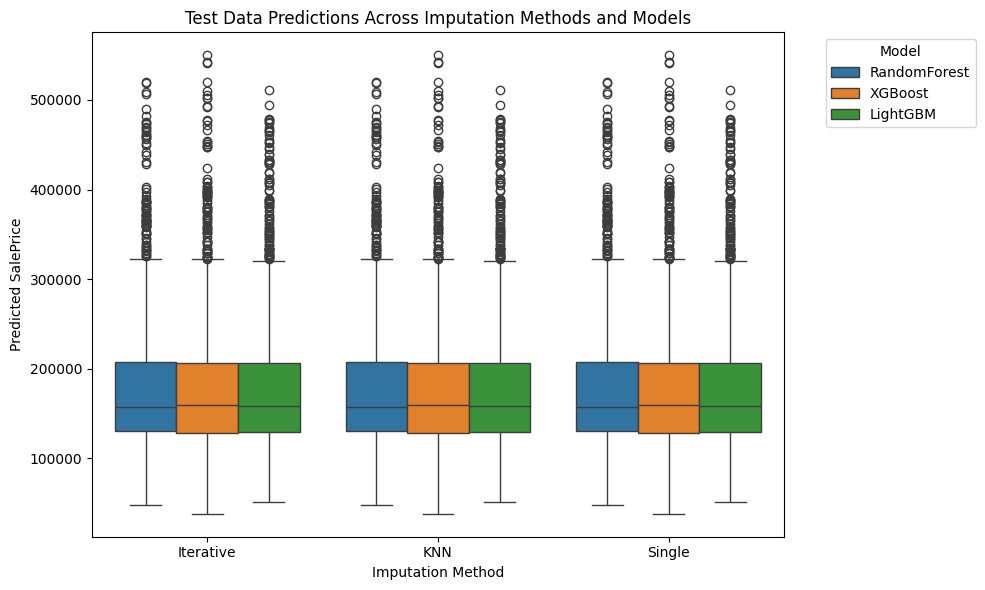

In [45]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=test_preds_df, x="Imputation", y="Prediction", hue="Model")
plt.title("Test Data Predictions Across Imputation Methods and Models")
plt.ylabel("Predicted SalePrice")
plt.xlabel("Imputation Method")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [46]:
print("\nSummary Statistics for Test Predictions:")
print(test_preds_df.groupby(["Imputation", "Model"])["Prediction"].describe())


Summary Statistics for Test Predictions:
                          count           mean           std           min  \
Imputation Model                                                             
Iterative  LightGBM      1459.0  178990.506405  75551.334799  51035.062151   
           RandomForest  1459.0  178691.871270  74812.012340  47780.000000   
           XGBoost       1459.0  178856.075059  76595.785793  38201.582031   
KNN        LightGBM      1459.0  178998.095410  75547.475648  51035.062151   
           RandomForest  1459.0  178703.835869  74800.224713  47780.000000   
           XGBoost       1459.0  178873.180943  76585.620543  38201.582031   
Single     LightGBM      1459.0  179005.558007  75537.881487  51035.062151   
           RandomForest  1459.0  178714.178384  74790.543961  47780.000000   
           XGBoost       1459.0  178864.281638  76586.277734  38201.582031   

                                   25%            50%            75%  \
Imputation Model           

/Users/meskara/Library/Python/3.9/lib/python/site-packages/numpy/ma/extras.py:648: RuntimeWarning: invalid value encountered in scalar divide
  avg = np.multiply(a, wgt,


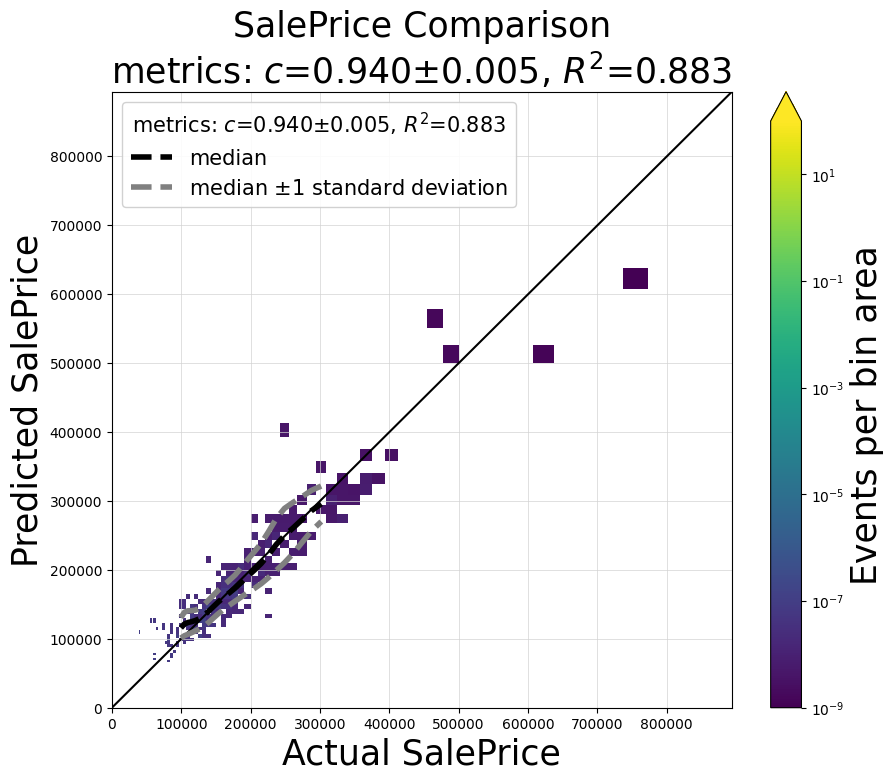

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.ndimage import gaussian_filter
from sklearn.metrics import r2_score

# --------------------------------------------------------------------------
# 2) 2D Correlation Plot: Actual vs. Predicted SalePrice
# --------------------------------------------------------------------------

def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

def corr_err(x, y, w):
    """Weighted Correlation Error"""
    return np.sqrt((1. - (corr(x, y, w))**2) / (len(x)-2))

def weighted_avg_and_std(values, weights):
    """Return the weighted average and standard deviation."""
    average = np.ma.average(values, weights=weights)
    variance = np.ma.average((values - average)**2, weights=weights)
    return (average, np.sqrt(variance))

def weighted_quantiles(values, weights, quantiles=0.5, interpolate=False):
    if len(values):
        i = values.argsort()
        sorted_weights = weights[i]
        sorted_values = values[i]
        Sn = sorted_weights.cumsum()
        if interpolate:
            Pn = (Sn - sorted_weights/2) / Sn[-1]
            return np.interp(quantiles, Pn, sorted_values)
        else:
            return sorted_values[np.searchsorted(Sn, quantiles * Sn[-1])]
    else:
        return np.nan

w = np.ones_like(y_test_original)

BINS = np.append([0], np.logspace(np.log10(y_test_original.min()*0.8), 
                                   np.log10(y_test_original.max()*1.2), 70))

H, x_bin_edges, y_bin_edges = np.histogram2d(
    y_test_original, y_pred,
    bins=[BINS, BINS],
    weights=w
)
counts, _, _ = np.histogram2d(y_test_original, y_pred, bins=[BINS, BINS])

x_bin_centers = 0.5 * (x_bin_edges[:-1] + x_bin_edges[1:])
y_bin_centers = 0.5 * (y_bin_edges[:-1] + y_bin_edges[1:])

x_temp = np.asarray(y_test_original)
y_temp = np.asarray(y_pred)

xses = np.floor(x_bin_centers).astype(int)

avgs = np.array([weighted_quantiles(
                    y_temp[(x_temp >= x_bin_edges[i]) & (x_temp < x_bin_edges[i+1])],
                    weights=w[(x_temp >= x_bin_edges[i]) & (x_temp < x_bin_edges[i+1])],
                    quantiles=0.5, interpolate=False)
                 for i in range(len(x_bin_centers))])
stds = np.array([weighted_avg_and_std(
                    y_temp[(x_temp >= x_bin_edges[i]) & (x_temp < x_bin_edges[i+1])],
                    weights=w[(x_temp >= x_bin_edges[i]) & (x_temp < x_bin_edges[i+1])])[1]
                 for i in range(len(x_bin_centers))])

cts = np.array([np.sum((x_temp >= x_bin_edges[i]) & (x_temp < x_bin_edges[i+1]))
                for i in range(len(x_bin_centers))])

sig = 1.5
avg_m_std = avgs - stds
low_slc = avg_m_std > -np.inf

x_up = xses
y_up = gaussian_filter(avgs + stds, sigma=sig)
x_mid = x_up
y_mid = gaussian_filter(avgs, sigma=sig)
x_down = xses[low_slc]
y_down = gaussian_filter(avg_m_std, sigma=sig)[low_slc]

dx = np.diff(BINS)
area = dx[:, None] * dx

plt.figure(figsize=(10, 8))
pcm = plt.pcolormesh(
    x_bin_edges,
    y_bin_edges,
    (H / area).T,
    cmap='viridis',
    norm=LogNorm(vmin=1e-9, vmax=1e2),
    shading='auto'
)

plt.xlabel("Actual SalePrice", fontsize=25)
plt.ylabel("Predicted SalePrice", fontsize=25)
plt.grid(color='lightgray', linestyle='-', linewidth=0.5, zorder=-1)
plt.plot(plt.xlim(), plt.ylim(), color='k', linestyle='-')  

plt.plot(x_mid, y_mid, color='k', linestyle='dashed', linewidth=4, label='median')
plt.plot(x_down, y_down, color='gray', linestyle='dashed', linewidth=4)
plt.plot(x_up, y_up, color='gray', linestyle='dashed', linewidth=4,
         label='median $\pm$1 standard deviation')

trues = []
preds = []
bin_weights = []
for xbe in range(len(x_bin_edges)-1):
    for ybe in range(len(y_bin_edges)-1):
        current_bin = ((x_temp >= x_bin_edges[xbe]) & (x_temp < x_bin_edges[xbe+1]) &
                       (y_temp >= y_bin_edges[ybe]) & (y_temp < y_bin_edges[ybe+1]))
        bin_weights.append(np.sum(w[current_bin]))
        trues.append(x_bin_edges[1:][xbe])
        preds.append(y_bin_edges[1:][ybe])
trues = np.array(trues)
preds = np.array(preds)
bin_weights = np.array(bin_weights)


c_val = corr(trues, preds, bin_weights)
c_err_val = corr_err(trues, preds, bin_weights)
r2_val = r2_score(trues, preds, sample_weight=bin_weights)
s = f'metrics: $c$={c_val:.3f}$\\pm${c_err_val:.3f}, $R^2$={r2_val:.3f}'

plt.title('SalePrice Comparison\n' + s, fontsize=25)
plt.legend(title=s, title_fontsize=15, fontsize=15, markerscale=1, loc='upper left', framealpha=0.9)
plt.colorbar(pcm, extend='max').set_label(label='Events per bin area', size=25)
plt.show()